# Método del Relé

Permite con un simple ensayo obtener el punto crítico.
Se intercala un relé en el lazo, de manera que 
$$ u=h \cdot sign(e) $$


In [ ]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

Sistema a identificar


StateSpace(array([[-3.2, -3.6, -0.6],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ]]), array([[1.],
       [0.],
       [0.]]), array([[ 0.2, -0.6,  0.6]]), array([[0.]]))

Text(0, 0.5, '$u(t)$')

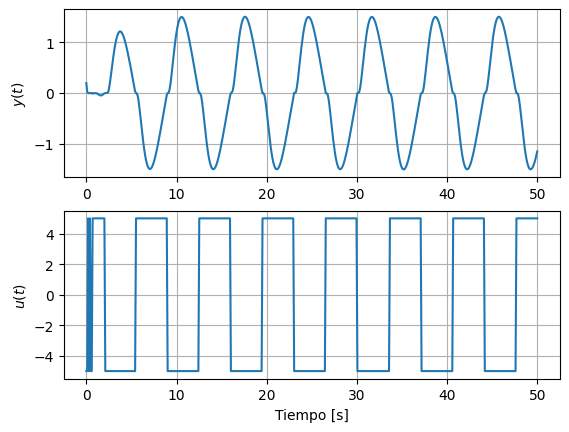

In [ ]:
# Parámetros de la planta
tau = 5
K = 1
L = 2
# Apertura del relay
hh = 5

r = 0

# Defino la planta (primer orden con retardo ... pero el retardo va con Pade)
s = ctrl.TransferFunction.s
num_p, den_p = ctrl.pade(L, 2)
G = ctrl.series( K / (tau*s + 1) , ctrl.tf(num_p, den_p))
Gss = ctrl.tf2ss(G)
print('Sistema a identificar')
display(Gss)

# Vamos a excitarla en lazo cerrado interponiendo un relé
def modelo(t, x):
    x = np.reshape(x,(-1,1))    
    y = float(Gss.C @ x)
    e = r-y
    u = hh * np.sign(e)                                                                                                                                                                                                                                                                                                             
    xd = Gss.A @ x + Gss.B * u
    return xd.flatten()

t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 500)
sol = solve_ivp(modelo, t_span, [1,0,0], t_eval=t_eval, method='RK45')

# Recupero la salida de la planta desde los estados
t = sol.t
y = (Gss.C @ sol.y).flatten() + float(Gss.D)*0.0

# Recupero la señal de entrada a la planta (la salida del relé)
u = np.array([hh*np.sign(-yt) for yt in y])

#t,y = ctrl.step_response(Gss)

plt.subplot(211)
plt.plot(t,y)
plt.grid()
plt.ylabel('$y(t)$')
plt.subplot(212)
plt.plot(t,u)
plt.grid()
plt.xlabel('Tiempo [s]')
plt.ylabel('$u(t)$')


In [ ]:
# Realizo mediciones sobre las señales
from scipy.signal import find_peaks

idx = (3*len(y))//4
print(f"Analizando salida luego de transitorios t={t[idx]:.1f}")
y_perm = y[idx:-1]
u_perm = u[idx:-1]
peaks, _ = find_peaks(y_perm)  
# promedio de distancia entre picos
Tu = np.mean(np.diff(t[peaks]))  
print(f"Periodo de oscilación Tu ={Tu:.2f}")
print(f"Periodo de oscilación w_u ={2*np.pi/Tu:.2f}")

a = (np.max(y_perm) - np.min(y_perm)) / 2
print(f"Amplitud de oscilación Yp                                                                                                                                                                                                                                                                                            = {a:.2f}")

Ku = 4*hh / (np.pi * a)
print(f"Ganancia crítica Ku = {Ku:.2f}")

Analizando salida luego de transitorios t=37.6
Periodo de oscilación Tu =7.11
Periodo de oscilación w_u =0.88
Amplitud de oscilación Yp = 1.50
Ganancia crítica Ku = 4.24


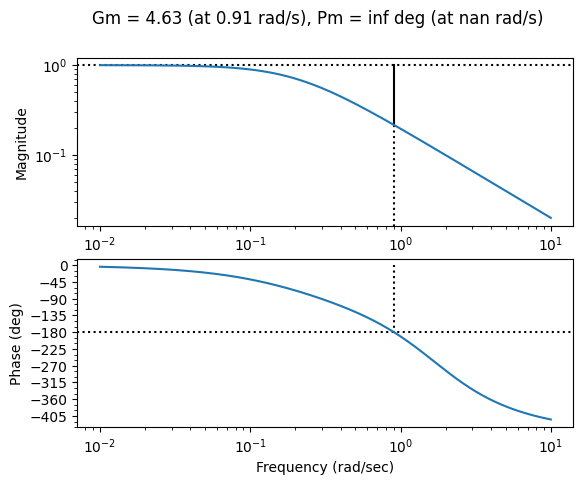

In [ ]:
# Corroboramos el resultado de la identificación en la planta teórica
mag, phase, omega = ctrl.bode_plot(G,plot=True,margins=True)

# Respuesta en frecuencia

Se excita la planta con senoidales de frecuencia distintas frecuencias y se registra la amplitud y desfasaje de la salida para relevar el Bode

Casos a investigar: 
- v es ruido blanco
- v es ruido rosado
- v es una constante
- v es una senoidal a una frecuencia fija
- se identifica con un período de muestreo alto


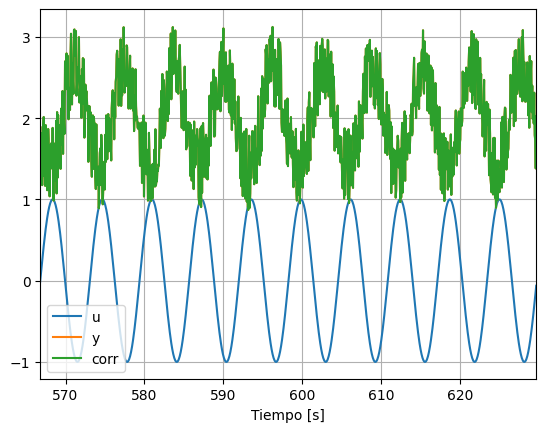

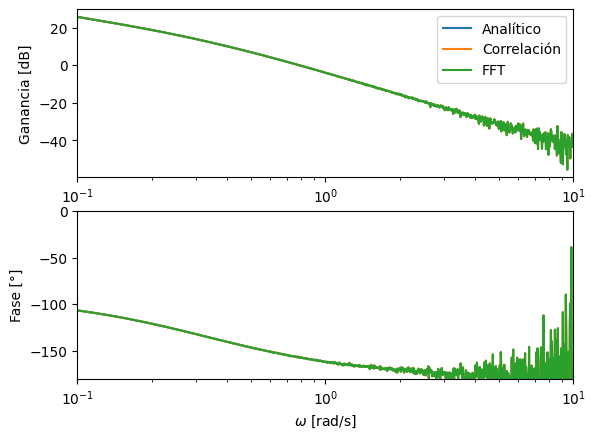

In [ ]:
# Respuesta en Frecuencia de un Motor de CC
s=ctrl.TransferFunction.s

# Modelo de la Planta
G= 2/s/(3*s+1)

# Bode Exacto 
mag,phase,w_calc = ctrl.bode_plot(G,plot=False)

# Amplitud de la senoidal de prueba
u1 = 1
# Amplitud de la perturbación
v1 = 1

mag_ident = np.zeros_like(mag)
phase_ident = np.zeros_like(phase)
mag_ident_fft = np.zeros_like(mag)
phase_ident_fft = np.zeros_like(phase)

i = 0
# Ensayo para las frecuencias que calculó el bode "analítico"
n_w_analisis = len(w_calc)
for w in w_calc[0:n_w_analisis]:
    # Tiempo del ensayo
	# Considero nwc ciclos muestreado a ws=nws*w
    nw_ciclos = 100
    nw_samples = 100
    t = np.arange(0, 2*np.pi/w*nw_ciclos, 2*np.pi/w/nw_samples)   # tiempo de simulación
    N = int(0.8*nw_ciclos)*nw_samples
    idx_analisis = len(t)-np.arange(N,0,-1)

    u = u1*np.sin(w*t)
    # Respuesta con perturbación
    v = v1*(np.random.rand(len(t))-.5)
    # Perturbación senoidal a w=0.5 rad/s
    #v = v1*np.sin(0.5*t)
    # Perturbación rampa
    #v = v1*t

    t_sim,y  = ctrl.forced_response(G, T=t, U=u) + v 

    # Analisis por correlación	
    Ic = np.sum(y[idx_analisis] * np.cos(w*t[idx_analisis]))
    Is = np.sum(y[idx_analisis] * np.sin(w*t[idx_analisis]))
    mag_ident[i] = np.sqrt(Ic**2+Is**2)*2/u1/N
    phase_ident[i] = np.arctan2(Ic,Is)

    # Analisis por FFT
    Y = np.fft.fft(y[idx_analisis])
    U = np.fft.fft(u[idx_analisis])
    k = np.argmin(np.abs(np.fft.fftfreq(len(idx_analisis), t[1]-t[0])*2*np.pi - w))
    H = Y[k] / U[k] 	
    mag_ident_fft[i] = np.abs(H)
    phase_ident_fft[i] = np.angle(H)

    i+=1
    if i==n_w_analisis//2:
        plt.figure()
        plt.plot(t,u, label='u')
        plt.plot(t,y,label='y')
        plt.plot(t[idx_analisis],y[idx_analisis],label='corr')
        plt.xlim(t[-10*nw_samples],t[-1])
        plt.xlabel('Tiempo [s]')
        plt.grid()
        plt.legend()
        plt.show()

# Limito el valor de la fase entre 0 y -2pi
fase_corr = np.where(phase_ident > 0, phase_ident - 2*np.pi, phase_ident)
fase_corr_fft = np.where(phase_ident_fft > 0, phase_ident_fft - 2*np.pi, phase_ident_fft)

plt.figure()
plt.subplot(211)
plt.semilogx(w_calc,20*np.log10(mag),label='Analítico')
plt.semilogx(w_calc,20*np.log10(mag_ident),label='Correlación')
plt.semilogx(w_calc,20*np.log10(mag_ident_fft),label='FFT')
plt.xlim(w_calc[0],w_calc[n_w_analisis-1])
plt.ylabel('Ganancia [dB]')
plt.grid;plt.legend()
plt.subplot(212);
plt.semilogx(w_calc,phase*180/np.pi,label='Analítico');
plt.semilogx(w_calc,fase_corr*180/np.pi,label='Correlación')
plt.semilogx(w_calc,fase_corr_fft*180/np.pi,label='FFT')

plt.xlim(w_calc[0],w_calc[n_w_analisis-1])
plt.ylim(-180,0)
plt.ylabel('Fase [°]')
plt.xlabel('$\omega$ [rad/s]')
plt.grid;#plt.legend()
plt.show()
